## Reiter Method
The Reiter Method is the most common way of calculating impulse response functions for heterogenous agent models. Here, we implement this for our Aiyagari Economy.

#### Preliminaries

In [1]:
# load some packages
from jax.experimental import sparse
from scipy.optimize import brentq
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
import jax.numpy as jnp  # we'll need autodifferentiation
import warnings
import jax
jax.config.update('jax_enable_x64', True)  # jax uses 32 bit numbers for some reason

# config
A_MIN = 0
A_MAX = 500
N_A = 501
LABOR_EFFICIENCY = jnp.array([1, 2.5])  # low and high endowments
L_L = 0.4  # probability of staying low
H_H = 0.8  # probability of staying high
TRAN_MAT = jnp.array([[L_L, 1-H_H], [1-L_L, H_H]])  # transition matrix
ALPHA = 0.4
BETA = 0.98
GAMMA = 2.
DELTA = 0.02
RHO_Z = 0.95
SIGMA_Z = 0.02

#### The Model
The models follows from the Aiyagari Economy with the addition of a exogenous productivity shocks that follows an AR(1) process.

The model is populated by a unit continuum of households with CRRA preferences given by
$$
\mathbb{E} \sum_{t=0}^\infty \beta^t \frac{c_{i, t}^{1-\gamma}}{1-\gamma}
$$
and a budget given by
$$
k_{i, t} + c_{i, t} = R_t k_{i, t-1} + W_t \ell_{i, t}.
$$
where $\ell_{i, t}$ is individual $i$'s labor efficiency at time $t$ that fluctuates between $\ell_l$ and $\ell_h$ where $\ell_l < \ell_h$ with by an exogenous process with transition probabilities $\Pi(\ell' \mid \ell)$.

The distribution of households is defined as $\Gamma(k_{t-1}, \ell_t)$.

Production takes place in a representative firm such that
$$
Y_t = Z_t K_{t-1}^\alpha L_t^{1-\alpha}
$$
The FOCs for the firm problem are
\begin{align*}
R_t &= \alpha Z_t K_{t-1}^{\alpha - 1} L_t^{\alpha - 1} + 1 - \delta \\
W_t &= (1-\alpha) Z_t K_{t-1}^\alpha L_t^{-\alpha}.
\end{align*}

$Z_t$ follows the AR(1) process
$$
\log Z_t = \rho_Z \log Z_{t-1} + \varepsilon_Z
$$
where $\varepsilon_Z \sim \mathcal{N} (0, \sigma_Z^2)$.

The variables in the model represent
| Variable | Meaning |
| --- | --- |
| $c_{i, t}$ | Individual $i$'s consumption at time $t$ |
| $\ell_{i, t}$ | Individual $i$'s labor efficiency at time $t$ |
| $k_{i, t}$ | Individual $i$'s capital stock at time $t$ |
| $Y_t$ | Output at time $t$ |
| $K_t$ | Aggregate capital stock at time $t$ |
| $L_t$ | Aggregate labor supply at time $t$ |
| $R_t$ | Rental rate of capital at time $t$ |
| $W_t$ | Wage rate at time $t$ |
| $Z_t$ | Exogenous productivity level for the economy at time $t$ |

and the parameters in the model represent
| Parameter | Meaning |
| --- | --- |
| $\beta$ | Intertemporal discount factor |
| $\gamma$ | Risk aversion parameter |
| $\alpha$ | Cobb Douglas parameter |
| $\delta$ | Capital depreciation rate |
| $\rho_Z$ | Regression to the mean for $Z_t$ |
| $\sigma_Z$ | Standard deviation of the productivity shocks |

#### The Method
At a high level, the Reiter Method creates a linear approximation around the stationary distribution.

To do this, we need to first create a `residual` function which should be 0 for any valid solutions. This should contain
- Household Euler Equations
- Transitions through the distribution
- Aggregators and overall conditions

Then, we represent the current economy as a vector of
- Savings levels for each of the gridpoints (Policy Rules)
- % of the Population at each of the gridpoints (Distribution)
- Aggregates

#### Labor Supply
Use eigenvectors to solve for the labor supply

In [2]:
# get eigenstuff
vals, vecs = jnp.linalg.eig(TRAN_MAT)
vals, vecs = vals.real, vecs.real
i = vals.argmax()

# get the distribution
labor_dist = vecs[:, i]  # get dominant eigenvector
labor_dist /= labor_dist.sum()  # vector reprsents percentages, normlaize it to sum to 1
L = (labor_dist * LABOR_EFFICIENCY).sum()  # aggragate labor is the dot product between the distribution and efficeicies

L

Array(2.125, dtype=float64)

#### Setup
Setup the grids we'll use for the EGM

In [3]:
# gridpoints
grid = jnp.linspace(A_MIN**(1/4), A_MAX**(1/4), N_A)**4
# we use a grid with more points near the borrowing constraint since there is more curvature there, see Reiter 2009
tiled_grid = jnp.tile(grid, LABOR_EFFICIENCY[:, None].shape).T  # each row is a different income level. Represent g as a function of only this vector

#### Helper Functions
Functions to help interpolate and get policy functions from an economy.

In [4]:
def get_linear_interpolation(x, y):
    '''
    Gets a function that performs a linear interpolation between the
    points in x and y

    If check input is left false, the x values should be sorted and 
    unique
    '''
    # setuo
    n = len(x)
    
    # create and return interpolating function
    def linear_interpolation(X):
        '''
        The function to find the interpolating spline at an X
        '''
        idx = jnp.minimum(jnp.maximum(jnp.searchsorted(x, X, 'right'), 1), n-1)  # min an max make sure that points before/after end up on a line
        x_l = x[idx-1]  # values below the x
        y_l = y[idx-1]
        x_h = x[idx]  # values above the x
        y_h = y[idx]
        m = (y_h - y_l) / (x_h - x_l)  # slope
        return y_l + m*(X - x_l)  
    
    return linear_interpolation


def get_g(a, A=tiled_grid, spline=get_linear_interpolation):
    '''
    Takes current asset grid and future asset grid and interpolates to
    make a savings function
    '''
    # get interpolating functions
    num_endows = a.shape[1]
    splines = [spline(a[:, i], A[:, i]) for i in range(num_endows)]

    def g(a):
        '''
        Savings function, takes asset grid and returns how much they save
        '''
        a_prime = jnp.column_stack([splines[i](a[:, i]) for i in range(num_endows)])
        a_prime = a_prime.at[a_prime < A_MIN].set(A_MIN)
        return a_prime
    
    return g


def get_c(g, R, W):
    '''
    Takes a saving function and returns the consumption function
    '''
    c = lambda a: R*a + W*LABOR_EFFICIENCY - g(a)  # consumption = assets + endowment - next assets
    return c

#### Steady State
Use the method used to find the steady state for the Aiyagri Economy to get the pre-shock steady state for the economy

The code has all been updated to work with JAX so autodifferentiation works.

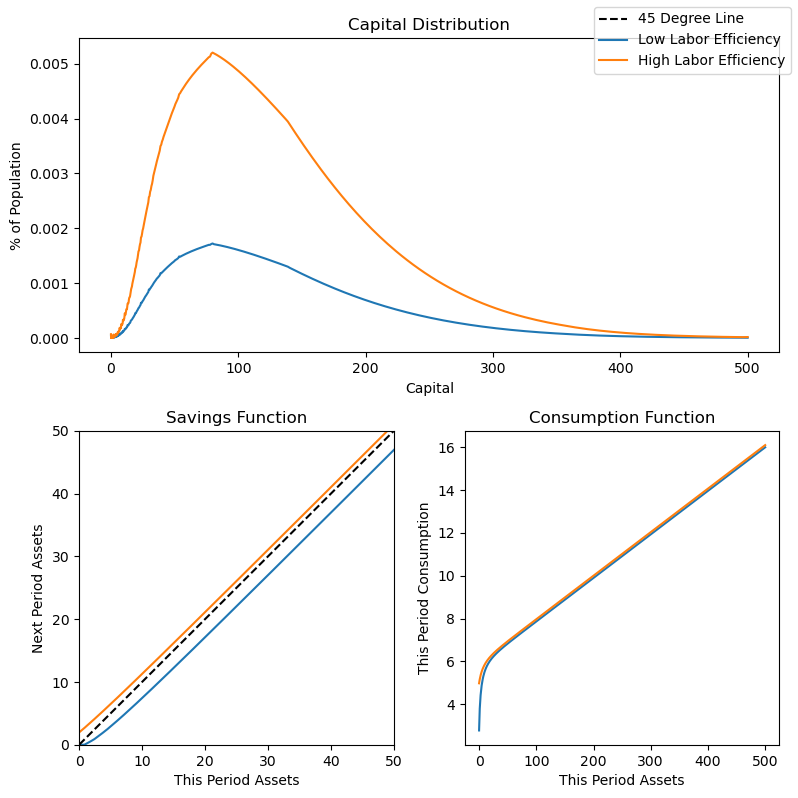

In [5]:
# initial guess
# initial guess for K
K_0 = ((1/BETA - 1 + DELTA) / (ALPHA * L**(1-ALPHA)))**(1/(ALPHA - 1))  # keep as seperate variable to use in loop 
R = ALPHA * K_0**(ALPHA-1) * L**(1-ALPHA) + 1 - DELTA
W = (1-ALPHA) * K_0**ALPHA * L**(-ALPHA)

# capital guess loop params
capital_max_iter = 100  # max number of gueses for capital
capital_tol = 1e-16  # actual capital will be within this distance of capital

# policy function loop params
policy_max_iter = 10000  # max number of guesses for the policy function
policy_tol = 1e-16  # loop until two iterations are within this distance max of each other

# params
a_current = 10 + 0.1*tiled_grid  # assumed policy function is that you save this amount from each point in the tiled grid
g = get_g(a_current)
c = get_c(g, R, W)
current_funcs = [g, c]  # we store the functions in a mutable object so the last iterations function can be used for the next iteration

# simulation function
def simulate_K(K, tol=policy_tol, max_iter=policy_max_iter):
    g, c = current_funcs

    # find r and w based on our current guess
    R = ALPHA * K**(ALPHA-1) * L**(1-ALPHA) + 1 - DELTA
    W = (1-ALPHA) * K**ALPHA * L**(-ALPHA)

    ## find policy function for this capital level
    for _ in range(max_iter):
        # update rule
        c_prime = c(tiled_grid)
        deriv_u_prime = c_prime**(-GAMMA)
        expect_deriv_u_prime = deriv_u_prime @ TRAN_MAT  # expectation
        c_current = (BETA * R * expect_deriv_u_prime)**(-1/GAMMA)
        a_current = 1/R * (c_current + tiled_grid - W*LABOR_EFFICIENCY)

        # make functions
        g, last_g = get_g(a_current), g
        c = get_c(g, R, W)

        # exit conditions
        diff = jnp.abs(g(tiled_grid) - last_g(tiled_grid)).max()
        if diff < tol:
            break
    else:
        warnings.warn('Policy Loop: Max iteration count exceeded')

    ## get the stationary distribution of capital
    grid_save = g(tiled_grid)  # how much you save at each gridpoint
    idxs = jnp.minimum(jnp.searchsorted(grid, grid_save, 'right'), N_A-1)  # upper of the two adjacent indicies to where g maps
    p_l = jnp.maximum((grid[idxs] - grid_save) / (grid[idxs] - grid[idxs-1]), 0)  # how close it is to the lower of the gridpoints we map to 
    # 1 -> it maps to the lower girdpoint, 0 -> it maps to the higher girdpoint, 0.5 -> its halfway between both
    p_h = 1 - p_l  # how close it is to the upper half

    # create transition matricies
    # low wage: capital now -> capital later
    data_l = jnp.concatenate([p_l[:, 0], p_h[:, 0]])
    mask_l = data_l != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_l = data_l[mask_l]
    row_l = jnp.concatenate([idxs[:, 0]-1, idxs[:, 0]])[mask_l]
    col_l = jnp.concatenate([jnp.arange(N_A), jnp.arange(N_A)])[mask_l]

    # high wage: capital now -> capital later
    data_h = jnp.concatenate([p_l[:, 1], p_h[:, 1]])
    mask_h = data_h != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_h = data_h[mask_h]
    row_h = jnp.concatenate([idxs[:, 1]-1, idxs[:, 1]])[mask_h]
    col_h = jnp.concatenate([jnp.arange(N_A), jnp.arange(N_A)])[mask_h]

    # create overall transition matrix
    data = jnp.concat((
            (data_l * TRAN_MAT[:, [0]]).ravel(),  # multiply by probabilities
            (data_h * TRAN_MAT[:, [1]]).ravel(),  # multiply by porbabilities
        ))
    row = jnp.concat((
            row_l, N_A + row_l,  # top vector (low endowment) is on top
            row_h, N_A + row_h,
        ))
    col = jnp.concat((
            col_l, col_l,  # left half of transition matrix 
            N_A + col_h, N_A + col_h,  # right half of transition matrix
        ))
    tran_mat = sparse.BCOO((data, jnp.column_stack((row, col))), shape=(2*N_A, 2*N_A))

    # use eigenvalues to get the steady state distribution of capital
    vals, vecs = jnp.linalg.eig(tran_mat.todense())  # TODO: Sparse implementation?
    i = jnp.abs(vals).argmax()
    dist = vecs[:, i].real  # dominant eigenvector
    dist /= dist.sum()  # normalize to sume to 1
    dist = dist.reshape((-1, 2), order='F')  # reshape to keep track of labor efficiency state, first column is low, second is high

    # get aggregate demand
    K_d = (grid * dist.T).sum()
    current_funcs[0], current_funcs[1] = g, c
    return K_d, R, W, c, g, dist, a_current

# find equalibrium
K = brentq(lambda K: simulate_K(K)[0] - K, K_0, K_0+2., xtol=capital_tol, maxiter=capital_max_iter)
_, R, W, c, g, dist, a_current = simulate_K(K)  # get the economic variables

# setup plot
fig, axs = plt.subplots(2, 2)
fig.set_figwidth(8)
fig.set_figheight(8)
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:  # remove the axis so we can have one big one
    ax.remove()
axtop = fig.add_subplot(gs[0, :])
axtop.set_title('Capital Distribution')
axtop.set_xlabel('Capital')
axtop.set_ylabel('% of Population')
axs[1, 0].set_title('Savings Function')
axs[1, 0].set_xlabel('This Period Assets')
axs[1, 0].set_ylabel('Next Period Assets')
axs[1, 0].set_xlim((0, 50))  # all the interesting stuff happens closer to 0
axs[1, 0].set_ylim((0, 50))
axs[1, 1].set_title('Consumption Function')
axs[1, 1].set_xlabel('This Period Assets')
axs[1, 1].set_ylabel('This Period Consumption')

# plot it
axtop.plot(grid, dist[:, 0], label='Low Labor Efficiency')
axtop.plot(grid, dist[:, 1], label='High Labor Efficiency')
axs[1, 0].plot(grid, g(tiled_grid))
axs[1, 0].plot([A_MIN, A_MAX], [A_MIN, A_MAX], 'k--', label='45 Degree Line')
axs[1, 1].plot(grid, c(tiled_grid))

# final things
fig.legend()
fig.tight_layout()

#### Residual
We'll create a residual function for all the variables needed to map the economy's path through time including
- The savings functions
- The distribution of wealth
- The aggregate level of capital
- The productivity level

In [6]:
# price functions
R_f = lambda K_l, Z_t: ALPHA * Z_t * K_l**(ALPHA-1) * L**(1-ALPHA) + 1 - DELTA
W_f = lambda K_l, Z_t: (1-ALPHA) * Z_t * K_l**ALPHA * L**(-ALPHA)

def residual(X_l, X_t, X_p, err):
    # get indivividual vectors
    decomp = lambda x: (  # decomposes output
            get_g(x[:2*N_A].reshape((-1, 2), order='F')),  # g, savings function goes from gridpoint to vector
            jnp.hstack((1-x[2*N_A:4*N_A-1].sum(), x[2*N_A:4*N_A-1])).reshape((-1, 2), order='F'),  # dist, sums to 1
            x[4*N_A-1], x[4*N_A]  # K, Z
        )
    g_l, dist_l, K_l, Z_l = decomp(X_l)
    g_t, dist_t, K_t, Z_t = decomp(X_t)
    g_p, _, _, Z_p = decomp(X_p)
    err_Z, = err

    # prices
    R_t = R_f(K_l, Z_t)
    R_p = R_f(K_t, Z_p)
    W_t = W_f(K_l, Z_t)
    W_p = W_f(K_t, Z_p)

    # consumption functions
    c_t = get_c(g_t, R_t, W_t)
    c_p = get_c(g_p, R_p, W_p)

    # euler residual
    c_prime = c_p(tiled_grid)
    deriv_u_prime = c_prime**(-GAMMA)
    expect_deriv_u_prime = deriv_u_prime @ TRAN_MAT  # expectation
    c_current = (BETA * R_t * expect_deriv_u_prime)**(-1/GAMMA)
    a_current = 1/R_t * (c_current + tiled_grid - W_t*LABOR_EFFICIENCY)
    euler_residual = c_t(a_current)**(-GAMMA) / c_current**(-GAMMA) - 1

    # distribution residual
    grid_save = g_t(tiled_grid)  # how much you save at each gridpoint
    idxs = jnp.minimum(jnp.searchsorted(grid, grid_save, 'right'), N_A-1)  # upper of the two adjacent indicies to where g maps
    p_l = jnp.maximum((grid[idxs] - grid_save) / (grid[idxs] - grid[idxs-1]), 0)  # how close it is to the lower of the gridpoints we map to 
    # 1 -> it maps to the lower girdpoint, 0 -> it maps to the higher girdpoint, 0.5 -> its halfway between both
    p_h = 1 - p_l  # how close it is to the upper half

    # low wage: capital now -> capital later
    data_l = jnp.concatenate([p_l[:, 0], p_h[:, 0]])
    mask_l = data_l != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_l = data_l[mask_l]
    row_l = jnp.concatenate([idxs[:, 0]-1, idxs[:, 0]])[mask_l]
    col_l = jnp.concatenate([jnp.arange(N_A), jnp.arange(N_A)])[mask_l]

    # high wage: capital now -> capital later
    data_h = jnp.concatenate([p_l[:, 1], p_h[:, 1]])
    mask_h = data_h != 0  # there can be zeros when a point perfectly matches a girdpoint
    data_h = data_h[mask_h]
    row_h = jnp.concatenate([idxs[:, 1]-1, idxs[:, 1]])[mask_h]
    col_h = jnp.concatenate([jnp.arange(N_A), jnp.arange(N_A)])[mask_h]

    # create overall transition matrix
    data = jnp.concat((
            (data_l * TRAN_MAT[:, [0]]).ravel(),  # multiply by probabilities
            (data_h * TRAN_MAT[:, [1]]).ravel(),  # multiply by porbabilities
        ))
    row = jnp.concat((
            row_l, N_A + row_l,  # top vector (low endowment) is on top
            row_h, N_A + row_h,
        ))
    col = jnp.concat((
            col_l, col_l,  # left half of transition matrix 
            N_A + col_h, N_A + col_h,  # right half of transition matrix
        ))
    tran_mat = sparse.BCOO((data, jnp.column_stack((row, col))), shape=(2*N_A, 2*N_A))
    dist_residual = dist_t.ravel('F') - tran_mat @ dist_l.ravel('F')

    # aggregate K
    K_dt = (grid * dist_t.T).sum()

    return jnp.hstack((
            euler_residual.ravel('F'),
            dist_residual[1:],
            K_dt - K_t,  # aggregate condition
            RHO_Z * jnp.log(Z_l) + err_Z - jnp.log(Z_t),  # productivity law of motion
        ))

# steady state vector
X_ss = jnp.hstack((
        a_current.ravel('F'),
        dist.ravel('F')[1:],
        K, 1.
    ))
err_ss = jnp.zeros(1)

# check our solution
assert jnp.allclose(residual(X_ss, X_ss, X_ss, err_ss), 0)

# get matricies
A = jax.jacfwd(lambda X_l: residual(X_l, X_ss, X_ss, err_ss))(X_ss)
B = jax.jacfwd(lambda X_t: residual(X_ss, X_t, X_ss, err_ss))(X_ss)
C = jax.jacfwd(lambda X_p: residual(X_ss, X_ss, X_p, err_ss))(X_ss)
E = jax.jacfwd(lambda err: residual(X_ss, X_ss, X_ss, err))(err_ss)

#### Linear Time Iteration
We'll use Linear Time Iteration from Rendahl (2017) to solve for policy rules

In [7]:
def linear_time_iteration(A, B, C, E, max_iter=1000, tol=1e-7):
    '''
    Implentation of Linear Time Iteration from Rendahl (2017) to find
    a policy rule for a dynamic system. 

    Note: This doesn't check BK solutions, so it can output invalid
    policy rules.
    '''
    # intial guess
    P = jnp.zeros_like(A)  # intial guess is all zeros

    # run incremental update algorithms
    for _ in range(max_iter):
        # update rule
        P = -jnp.linalg.inv(B + C@P) @ A

        # exit condition
        diff = jnp.abs(A + B@P + C@P@P).max()
        if diff < tol:
            break
    else:
        warnings.warn('Max iteration count exceeded')

    # get error matrix
    Q = -jnp.linalg.inv(B + C@P) @ E  # @E at the end keeps only releveant columns 

    return P, Q

P, Q = linear_time_iteration(A, B, C, E)

#### Impulse Response
Use our policy rule to simulate the response to a shock.

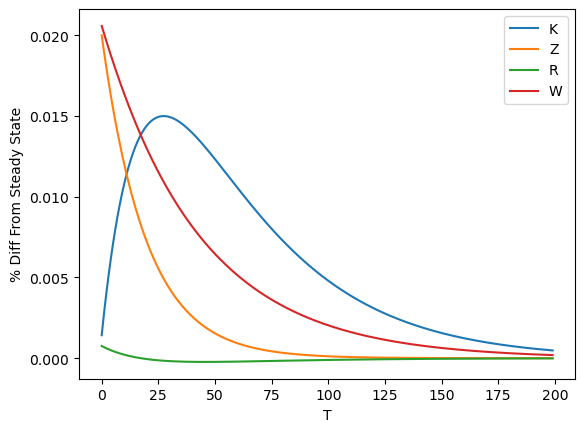

In [8]:
# config
T = 200

# simplate it
g_path = []
dist_path = []
K_path = []
Z_path = []
X = (Q * SIGMA_Z).ravel()
for t in range(1, T+1):
    # get variables
    g_path.append(get_g(a_current + X[:2*N_A].reshape((-1, 2), order='F')))
    dist_path.append(dist + jnp.hstack((-X[2*N_A:4*N_A-1].sum(), X[2*N_A:4*N_A-1])).reshape((-1, 2), order='F'))
    K_path.append(X[4*N_A-1])
    Z_path.append(X[4*N_A])

    # iterate to next period
    X = P @ X
K_path = jnp.array(K_path)
Z_path = jnp.array(Z_path)

# plot it
plt.xlabel('T')
plt.ylabel('% Diff From Steady State')
plt.plot(K_path / K, label='K')
plt.plot(Z_path / 1., label='Z')
plt.plot((R_f(K_path + K, Z_path + 1.) - R) / R, label='R')
plt.plot((W_f(K_path + K, Z_path + 1.) - W) / W, label='W')
plt.legend()

In [9]:
# animation
# setup plot
fig, axs = plt.subplots(2, 2)
fig.suptitle('t=0')
fig.set_figwidth(8)
fig.set_figheight(8)
gs = axs[0, 0].get_gridspec()
for ax in axs[0, :]:  # remove the axis so we can have one big one
    ax.remove()
axtop = fig.add_subplot(gs[0, :])
axtop.set_title('Capital Distribution')
axtop.set_xlabel('Capital')
axtop.set_ylabel('% of Population')
axtop.set_xlim((A_MIN, A_MAX))
axtop.set_ylim((0, 0.006))
axs[1, 0].set_title('Savings Function')
axs[1, 0].set_xlabel('This Period Assets')
axs[1, 0].set_ylabel('% Deviation from Steady State')
axs[1, 0].set_xlim((A_MIN, A_MAX))
axs[1, 0].set_ylim((-0.01, 0.03))
axs[1, 1].set_title('Consumption Function')
axs[1, 1].set_xlabel('This Period Assets')
axs[1, 1].set_ylabel('% Deviation from Steady State')
axs[1, 1].set_xlim((A_MIN, A_MAX))
axs[1, 1].set_ylim((-0.005, 0.02))

# plot it
ln_dist_low, = axtop.plot([], [], label='Low Labor Efficiency')
ln_dist_high, = axtop.plot([], [], label='High Labor Efficiency')
ln_g_low, = axs[1, 0].plot([], [])
ln_g_high, = axs[1, 0].plot([], [])
axs[1, 0].plot([A_MIN, A_MAX], [A_MIN, A_MAX], 'k--', label='45 Degree Line')
ln_c_low, = axs[1, 1].plot([], [])
ln_c_high, = axs[1, 1].plot([], [])

# final things
fig.legend()
fig.tight_layout()

# update frame
def update(t):
    fig.suptitle(f't={t}')

    # update distribution
    dist_t = dist_path[t]
    ln_dist_low.set_data(grid, dist_t[:, 0])
    ln_dist_high.set_data(grid, dist_t[:, 1])

    # update savings
    g_t = g_path[t]
    savings = (g_t(tiled_grid) - g(tiled_grid)) / g(tiled_grid)
    ln_g_low.set_data(grid, savings[:, 0])
    ln_g_high.set_data(grid, savings[:, 1])

    # update consumption
    K_l = K if t == 0 else K + K_path[t-1]
    Z_t = 1. + Z_path[t]
    consumption = (get_c(g_t, R_f(K_l, Z_t), W_f(K_l, Z_t))(tiled_grid) - c(tiled_grid)) / c(tiled_grid)
    ln_c_low.set_data(grid, consumption[:, 0])
    ln_c_high.set_data(grid, consumption[:, 1])
    

# animate it
plt.close()  # dont show empty figure
anim = animation.FuncAnimation(fig, update, frames=T, interval=50, repeat=False)
HTML(anim.to_html5_video())